In [32]:
from IPython.display import clear_output
from sys import executable

!{executable} -m pip install numpy pandas seaborn matplotlib sklearn graphviz nltk scipy deeppavlov catboost pandas_profiling russian_tagsets
clear_output()

In [10]:
!{executable} -m pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
clear_output()

In [11]:
# !{executable} -m deeppavlov install syntax_ru_syntagrus_bert
clear_output()

In [4]:
import numpy as np
import pandas as pd

import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import spatial
from statistics import mean
from scipy.cluster import hierarchy as sch

from deeppavlov import build_model, configs
from catboost import CatBoostClassifier, Pool

from nltk import word_tokenize, pos_tag
from nltk.translate import bleu_score
from nltk.translate.bleu_score import corpus_bleu

from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import re
import string
import pickle
from glob import glob
from io import StringIO

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
from nltk import download
download('punkt')
download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/mvshmakov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mvshmakov/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [7]:
%matplotlib inline
sns.set(context='notebook', style='darkgrid')
pd.set_option('display.float_format', lambda x: f'{x :.2f}')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [8]:
base_dir = "./"

# Reading dataset

In [12]:
def get_df_from_csvs_in_path(d, sep=';'):
    all_files = glob(d + "/*.csv")
    df_list = [pd.read_csv(filename, index_col=None, header=0, sep=sep) for filename in all_files]

    return pd.concat(df_list, axis=0, ignore_index=True)

In [13]:
blogs_processed_dir = base_dir + 'data/blogs/processed/'

df = get_df_from_csvs_in_path(blogs_processed_dir)

df = df.dropna().reset_index()
df

,index,EDU_1,EDU_2,Relation
0,0,"После поездки в 2017 на Бали я вспомнил, что о...","поэтому в 2018 полетели снова в теплые края, н...",cause_r
1,1,"поэтому в 2018 полетели снова в теплые края, н...","есть, что посмотреть.",preparation_r
2,2,(только сейчас руки дошли написать!).,"поэтому в 2018 полетели снова в теплые края, н...",evaluation_r
3,3,"В общем, прекрасное место!","поэтому в 2018 полетели снова в теплые края, н...",evaluation_r
4,4,"Остров не маленький,","есть, что посмотреть.",cause_r
...,...,...,...,...
11731,11752,и примерно такой же будет всегда.,она такая сейчас,sequence_m
11732,11753,Надеяться уже в принципе не на что.,"Это неотъемлемые свойства платформы,",joint_m
11733,11754,"И не то чтобы у меня было для вас что-то получше,",Надеяться уже в принципе не на что.,elaboration_r
11734,11755,"или что я могу сказать, где будущее.","И не то чтобы у меня было для вас что-то получше,",joint_m


In [14]:
df.describe()

,index
count,11736.00
mean,5881.30
std,3394.13
min,0.00
25%,2942.75
50%,5879.50
75%,8822.25
max,11756.00


# Feature extractors

In [15]:
features = ['num_of_words', 'avg_word_len', 'upcase_words_num', 'pos_tags', 'tf_idf']

In [16]:
test_edu = 'Современные технологии достигли такого уровня, что современная методология разработки создаёт предпосылки для позиций.'
test_edu_2 = 'Лишь базовые сценарии поведения пользователей, превозмогая сложившуюся непростую экономическую ситуацию.'

In [17]:
num_of_words = lambda edus: len(edus.split())
num_of_words(test_edu)

13

In [18]:
avg_word_len = lambda edus: mean([len(word) for word in edus.split()])
avg_word_len(test_edu)

8.153846153846153

In [19]:
upcase_words_num = lambda edu: len([word for word in edu.split() if word.istitle()])
upcase_words_num(test_edu)

1

In [20]:
num_unique_words = lambda edu: len(set(w for w in edu.split()))
num_unique_words(test_edu)

13

In [27]:
def pos_tags(edus):
    pos_tags = []

    for word in edus.split():
        word = word.lower()
        tokenized = word_tokenize(word)
        pos_tags.append(pos_tag(tokenized))

    return pos_tags

pos_tags(test_edu)

[[('современные', 'NN')],
 [('технологии', 'NN')],
 [('достигли', 'NN')],
 [('такого', 'NN')],
 [('уровня', 'NN'), (',', ',')],
 [('что', 'NN')],
 [('современная', 'NN')],
 [('методология', 'NN')],
 [('разработки', 'NN')],
 [('создаёт', 'NN')],
 [('предпосылки', 'NN')],
 [('для', 'NN')],
 [('позиций', 'NN'), ('.', '.')]]

In [ ]:
def tf_idf(edus):
    tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words=None, use_idf=True, min_df=1,
                                       smooth_idf=False, preprocessor=lambda edus: re.sub(r"[{}]".format(string.punctuation), " ", edus))

    return tfidf_vectorizer.fit_transform(edus.split())

# tf_idf(test_edu)

In [22]:
morph_correlation = lambda row, row_2: spatial.distance.correlation(row, row_2)
morph_canberra = lambda row, row_2: spatial.distance.canberra([row], [row_2])
morph_hamming = lambda row, row_2: spatial.distance.hamming(row, row_2)

# morph_correlation(tf_idf(test_edu), tf_idf(test_edu_2))

In [25]:
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.metrics import pairwise_distances 
from sklearn.metrics.pairwise import euclidean_distances 

def ang_cos_tf_idf_sim(tfidf_matrix, tfidf_matrix_2):
    cos_dist = cosine_similarity(tfidf_matrix[0], tfidf_matrix)
#     cos_dist = euclidean_distances(tfidf_matrix, tfidf_matrix_2)
#     cos_dist = pairwise_distances(tfidf_matrix, tfidf_matrix_2, metric = 'manhattan')
#     cos_dist = cosine_similarity(tfidf_matrix, tfidf_matrix_2)

    return np.arccos(cos_dist) * 2. / np.pi

# ang_cos_tf_idf_sim(tf_idf(test_edu), tf_idf(test_edu_2))

In [24]:
get_bleu_score = lambda row, row_2: bleu_score.sentence_bleu([row], row_2, weights=(0.5,))
get_bleu_score(test_edu, test_edu_2)

0.7808356939911968

# Features extraction

In [28]:
def apply_bleu(columns):
    return get_bleu_score(columns[0], columns[1])

def extract_features(target_df):
    target_df['num_of_words_1'] = target_df.EDU_1.apply(num_of_words)
    target_df['avg_word_len_1'] = target_df.EDU_1.apply(avg_word_len)
    target_df['upcase_words_num_1'] = target_df.EDU_1.apply(upcase_words_num)
    target_df['num_unique_words_1'] = target_df.EDU_1.apply(num_unique_words)
    target_df["count_words_title_1"] = target_df.EDU_1.apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    target_df["mean_word_len_1"] = target_df.EDU_1.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    target_df['words_vs_unique_1'] = target_df['num_unique_words_1'] / target_df['num_of_words_1']

    target_df['num_of_words_2'] = target_df.EDU_2.apply(num_of_words)
    target_df['avg_word_len_2'] = target_df.EDU_2.apply(avg_word_len)
    target_df['upcase_words_num_2'] = target_df.EDU_2.apply(upcase_words_num)
    target_df['num_unique_words_2'] = target_df.EDU_2.apply(num_unique_words)
    target_df["count_words_title_2"] = target_df.EDU_2.apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    target_df["mean_word_len_2"] = target_df.EDU_2.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    target_df['words_vs_unique_2'] = target_df['num_unique_words_2'] / target_df['num_of_words_2']

    target_df['bleu_score'] = list(map(apply_bleu, zip(target_df['EDU_1'], target_df['EDU_2'])))

    return target_df

extract_features(df)

,index,EDU_1,EDU_2,Relation,num_of_words_1,avg_word_len_1,upcase_words_num_1,num_unique_words_1,count_words_title_1,mean_word_len_1,words_vs_unique_1,num_of_words_2,avg_word_len_2,upcase_words_num_2,num_unique_words_2,count_words_title_2,mean_word_len_2,words_vs_unique_2,bleu_score
0,0,"После поездки в 2017 на Бали я вспомнил, что о...","поэтому в 2018 полетели снова в теплые края, н...",cause_r,19,4.42,2,18,2,4.42,0.95,12,4.67,2,11,2,4.67,0.92,0.54
1,1,"поэтому в 2018 полетели снова в теплые края, н...","есть, что посмотреть.",preparation_r,12,4.67,2,11,2,4.67,0.92,3,6.33,0,3,0,6.33,1.00,0.10
2,2,(только сейчас руки дошли написать!).,"поэтому в 2018 полетели снова в теплые края, н...",evaluation_r,5,6.60,0,5,0,6.60,1.00,12,4.67,2,11,2,4.67,0.92,0.63
3,3,"В общем, прекрасное место!","поэтому в 2018 полетели снова в теплые края, н...",evaluation_r,4,5.75,1,4,1,5.75,1.00,12,4.67,2,11,2,4.67,0.92,0.56
4,4,"Остров не маленький,","есть, что посмотреть.",cause_r,3,6.00,1,3,1,6.00,1.00,3,6.33,0,3,0,6.33,1.00,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11731,11752,и примерно такой же будет всегда.,она такая сейчас,sequence_m,6,4.67,0,6,0,4.67,1.00,3,4.67,0,3,0,4.67,1.00,0.29
11732,11753,Надеяться уже в принципе не на что.,"Это неотъемлемые свойства платформы,",joint_m,7,4.14,1,7,1,4.14,1.00,4,8.25,1,4,1,8.25,1.00,0.69
11733,11754,"И не то чтобы у меня было для вас что-то получше,",Надеяться уже в принципе не на что.,elaboration_r,11,3.55,1,11,1,3.55,1.00,7,4.14,1,7,1,4.14,1.00,0.54
11734,11755,"или что я могу сказать, где будущее.","И не то чтобы у меня было для вас что-то получше,",joint_m,7,4.29,0,7,0,4.29,1.00,11,3.55,1,11,1,3.55,1.00,0.70


In [33]:
# deeppavlov_model = build_model("ru_syntagrus_joint_parsing", download=True)
deeppavlov_model = build_model("ru_syntagrus_joint_parsing")

2020-06-08 16:23:15.629 INFO in 'deeppavlov.core.common.file'['file'] at line 32: Interpreting 'ru_syntagrus_joint_parsing' as '/usr/local/anaconda3/lib/python3.7/site-packages/deeppavlov/configs/syntax/ru_syntagrus_joint_parsing.json'
2020-06-08 16:23:15.933 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 115: [loading vocabulary from /Users/mvshmakov/.deeppavlov/models/morpho_ru_syntagrus/tag.dict]
2020-06-08 16:23:28.326 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 51: [loading model from /Users/mvshmakov/.deeppavlov/models/morpho_ru_syntagrus/model]


INFO:tensorflow:Restoring parameters from /Users/mvshmakov/.deeppavlov/models/morpho_ru_syntagrus/model


2020-06-08 16:23:30.0 WARNING in 'deeppavlov.core.models.serializable'['serializable'] at line 52: No load path is set for UDPymorphyLemmatizer!
2020-06-08 16:23:30.264 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 115: [loading vocabulary from /Users/mvshmakov/.deeppavlov/models/syntax_ru_syntagrus/deps.dict]


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



2020-06-08 16:23:46.439 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 51: [loading model from /Users/mvshmakov/.deeppavlov/models/syntax_ru_syntagrus/model_joint]


INFO:tensorflow:Restoring parameters from /Users/mvshmakov/.deeppavlov/models/syntax_ru_syntagrus/model_joint


In [34]:
from tqdm import tqdm
from datetime import datetime

columns_1 = ['nouns_count_1', 'verbs_count_1', 'adj_count_1', 'adv_count_1', 'aux_count_1', \
             'num_count_1', 'vbd_count_1', 'nouns_vs_words_1', 'adjectives_vs_words_1', 'verbs_vs_words_1',  \
             'adp_count_1', 'cconj_count_1', 'sconj_count_1', 'part_count_1', 'pron_count_1']
columns_2 = ['nouns_count_2', 'verbs_count_2', 'adj_count_2', 'adv_count_2', 'aux_count_2', \
             'num_count_2', 'vbd_count_2', 'nouns_vs_words_2', 'adjectives_vs_words_2', 'verbs_vs_words_2', \
             'adp_count_2', 'cconj_count_2', 'sconj_count_2', 'part_count_2', 'pron_count_2']

def extract_from_deeppavlov(target_df, boundaries, batch_number, batch_size=500):
    temp_df = pd.DataFrame(index=range(len(target_df)), columns=[*columns_1, *columns_2])

    for batch_index in tqdm(list(range(0, len(target_df), batch_size))):
        batch_1 = target_df.EDU_1[batch_index : batch_index+batch_size]
        batch_2 = target_df.EDU_2[batch_index : batch_index+batch_size]

        for idx, parsed_edu_tsv_1 in enumerate(deeppavlov_model(list(batch_1))):
            index = idx + batch_index
            parsed_edu_1 = pd.read_csv(StringIO(parsed_edu_tsv_1), sep='\t', header=None)

            temp_df['nouns_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'NOUN'])
            temp_df['verbs_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'VERB'])
            temp_df['adj_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'ADJ'])
            temp_df['adv_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'ADV'])
            temp_df['aux_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'AUX'])
            temp_df['num_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'NUM'])
            temp_df['vbd_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'VBD'])

            temp_df['adp_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'ADP'])
            temp_df['cconj_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'CCONJ'])
            temp_df['sconj_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'SCONJ'])
            temp_df['part_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'PART'])
            temp_df['pron_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'PRON'])

            temp_df['nouns_vs_words_1'][index] = temp_df['nouns_count_1'][index] / target_df['num_of_words_1'][index]
            temp_df['adjectives_vs_words_1'][index] = temp_df['adj_count_1'][index] / target_df['num_of_words_1'][index]
            temp_df['verbs_vs_words_1'][index] = temp_df['verbs_count_1'][index] / target_df['num_of_words_1'][index]

        for idx, parsed_edu_tsv_2 in enumerate(deeppavlov_model(list(batch_2))):
            index = idx + batch_index
            parsed_edu_2 = pd.read_csv(StringIO(parsed_edu_tsv_2), sep='\t', header=None)

            temp_df['nouns_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'NOUN'])
            temp_df['verbs_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'VERB'])
            temp_df['adj_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'ADJ'])
            temp_df['adv_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'ADV'])
            temp_df['aux_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'AUX'])
            temp_df['num_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'NUM'])
            temp_df['vbd_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'VBD'])

            temp_df['adp_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'ADP'])
            temp_df['cconj_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'CCONJ'])
            temp_df['sconj_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'SCONJ'])
            temp_df['part_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'PART'])
            temp_df['pron_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'PRON'])

            temp_df['nouns_vs_words_2'][index] = temp_df['nouns_count_2'][index] / target_df['num_of_words_2'][index]
            temp_df['adjectives_vs_words_2'][index] = temp_df['adj_count_2'][index] / target_df['num_of_words_2'][index]
            temp_df['verbs_vs_words_2'][index] = temp_df['verbs_count_2'][index] / target_df['num_of_words_2'][index]

    pd.merge(target_df, temp_df, left_index=True, right_index=True).to_csv(
        f'./deeppavlov_parsed/{"batch_" + str(batch_number) + "_" + str(boundaries)}.csv', index=None, sep='\t')
 
    return pd.merge(target_df, temp_df, left_index=True, right_index=True)

In [299]:
extract_from_deeppavlov(df[4000:4500].reset_index(), '4000_4500', 9)

100%|██████████| 1/1 [30:11<00:00, 1811.95s/it]


,level_0,index,EDU_1,EDU_2,Relation,num_of_words_1,avg_word_len_1,upcase_words_num_1,num_unique_words_1,count_words_title_1,...,num_count_2,vbd_count_2,nouns_vs_words_2,adjectives_vs_words_2,verbs_vs_words_2,adp_count_2,cconj_count_2,sconj_count_2,part_count_2,pron_count_2
0,4000,4009,"И, разумеется, вдоль было множество сторожевых...","В общем, это древняя дорога из одной части Гру...",joint_m,7,7.14,1,7,1,...,1,0,0.23,0.23,0.00,4,0,0,0,1
1,4001,4010,"Заброшенная церковь в Тавкавта, куда мы не поп...","Самое внятное описание этого места, найденное ...",elaboration_r,21,5.71,8,15,8,...,0,0,0.38,0.25,0.12,1,0,0,0,0
2,4002,4011,"Двигаясь назад,","нашли небольшую полянку у самой реки,",condition_r,2,7.00,1,2,1,...,0,0,0.33,0.33,0.17,1,0,0,0,0
3,4003,4012,устроили пикник.,"нашли небольшую полянку у самой реки,",joint_m,2,7.50,0,2,0,...,0,0,0.33,0.33,0.17,1,0,0,0,0
4,4004,4013,Монастырь оправдывает свое название,— ущелье Кавтуры действительно каменистое. Гру...,evidence_r,4,8.00,1,4,1,...,0,0,0.25,0.12,0.00,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,4495,4507,я ни когда туда не ходил,То есть как боялся:,elaboration_r,6,3.17,0,6,0,...,0,0,0.00,0.00,0.50,0,0,0,0,1
496,4496,4508,"и ни чего об этом не знал,",я ни когда туда не ходил,joint_m,7,2.86,0,7,0,...,0,0,0.00,0.00,0.17,0,0,0,2,1
497,4497,4509,но время от времени слушал страшные истории об...,я ни когда туда не ходил,contrast_m,11,5.55,0,11,0,...,0,0,0.00,0.00,0.17,0,0,0,2,1
498,4498,4510,и по-настоящему в это верил.,но время от времени слушал страшные истории об...,evaluation_r,5,4.80,0,5,0,...,0,0,0.36,0.09,0.18,2,1,0,0,0


# Data preprocessing

In [52]:
def get_df_from_csvs_in_path_2(d, sep=';'):
    all_files = glob(d + "/*.csv")
    df_list = [pd.read_csv(filename, index_col='level_0', header=0, sep=sep) for filename in all_files]

    return pd.concat(df_list, axis=0, ignore_index=True)

In [53]:
df = get_df_from_csvs_in_path_2('./data/blogs/deeppavlov_parsed', '\t')

df = df.dropna().reset_index()
df

,level_0,index,EDU_1,EDU_2,Relation,num_of_words_1,avg_word_len_1,upcase_words_num_1,num_unique_words_1,count_words_title_1,...,num_count_2,vbd_count_2,nouns_vs_words_2,adjectives_vs_words_2,verbs_vs_words_2,adp_count_2,cconj_count_2,sconj_count_2,part_count_2,pron_count_2
0,0,0,"После поездки в 2017 на Бали я вспомнил, что о...","поэтому в 2018 полетели снова в теплые края, н...",cause_r,19,4.42,2,18,2,...,1,0,0.17,0.08,0.08,4,0,0,0,0
1,1,1,"поэтому в 2018 полетели снова в теплые края, н...","есть, что посмотреть.",preparation_r,12,4.67,2,11,2,...,0,0,0.00,0.00,0.67,0,0,0,0,1
2,2,2,(только сейчас руки дошли написать!).,"поэтому в 2018 полетели снова в теплые края, н...",evaluation_r,5,6.60,0,5,0,...,1,0,0.17,0.08,0.08,4,0,0,0,0
3,3,3,"В общем, прекрасное место!","поэтому в 2018 полетели снова в теплые края, н...",evaluation_r,4,5.75,1,4,1,...,1,0,0.17,0.08,0.08,4,0,0,0,0
4,4,4,"Остров не маленький,","есть, что посмотреть.",cause_r,3,6.00,1,3,1,...,0,0,0.00,0.00,0.67,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11731,11731,2002,Стойте! А как же name?,"Не стоит забывать, что JavaScript мультипаради...",preparation_r,5,3.60,2,5,2,...,0,0,0.25,0.12,0.25,0,0,1,1,0
11732,11732,2003,"Не стоит забывать, что JavaScript мультипаради...","И лично для себя открыл в спецификации то, как...",background_r,8,8.75,1,8,1,...,0,0,0.23,0.00,0.15,3,1,0,0,2
11733,11733,2004,где есть элементы объектно-ориентированного по...,"Не стоит забывать, что JavaScript мультипаради...",elaboration_r,5,9.60,0,5,0,...,0,0,0.25,0.12,0.25,0,0,1,1,0
11734,11734,2005,где функцию можно рассматривать как объект со ...,где есть элементы объектно-ориентированного по...,elaboration_r,9,6.22,0,9,0,...,0,0,0.40,0.20,0.20,0,0,0,0,0


In [54]:
rels_to_classify = ['elaboration_r', 'evaluation_r', 'sequence_m']

def preprocess(target_df):
    global rels_to_classify

    # We need to bound the amount of available classes and memoize them
    if (len(rels_to_classify) == 0):
        counts = target_df.Relation.value_counts().loc[lambda x: x > 500]
        rels_to_classify = list(target_df.Relation[counts.index].index)
    target_df = target_df[target_df.Relation.isin(rels_to_classify)]

    # Encoding categorical Relation varible
    relations_mapping = {
        'elaboration_r': 0,
        'evaluation_r': 1,
        'sequence_m': 2}

    target_df.Relation = target_df.Relation.apply(lambda x: relations_mapping[x])

    # Drop categorical varibles
    categorical = target_df.select_dtypes(include=['object']).columns
    target_df.drop(columns=categorical, inplace=True)

    # MinMaxScaler scaling
    cols_without_relation = target_df.columns[target_df.columns != 'Relation']
    target_df[cols_without_relation] = StandardScaler().fit_transform(target_df[cols_without_relation])

    target_df.dropna(inplace=True)

    return target_df

In [55]:
df = preprocess(df)
rels_to_classify

['elaboration_r', 'evaluation_r', 'sequence_m']

In [56]:
df

,level_0,index,Relation,num_of_words_1,avg_word_len_1,upcase_words_num_1,num_unique_words_1,count_words_title_1,mean_word_len_1,words_vs_unique_1,...,num_count_2,vbd_count_2,nouns_vs_words_2,adjectives_vs_words_2,verbs_vs_words_2,adp_count_2,cconj_count_2,sconj_count_2,part_count_2,pron_count_2
2,-1.68,-1.76,1,-0.37,0.52,-0.33,-0.39,-0.33,0.52,0.22,...,1.84,0.00,-0.60,-0.08,-0.55,3.18,-0.50,-0.36,-0.48,-0.70
3,-1.67,-1.76,1,-0.54,-0.05,0.02,-0.60,0.02,-0.05,0.22,...,1.84,0.00,-0.60,-0.08,-0.55,3.18,-0.50,-0.36,-0.48,-0.70
7,-1.67,-1.76,0,-0.02,-0.74,0.02,0.01,0.02,-0.74,0.22,...,-0.36,0.00,-1.59,-0.73,3.04,-0.90,-0.50,-0.36,-0.48,0.66
8,-1.67,-1.76,0,2.22,-1.15,2.13,2.26,2.13,-1.15,-2.26,...,1.84,0.00,0.10,0.39,-0.18,0.12,-0.50,-0.36,-0.48,0.66
10,-1.67,-1.76,1,-0.71,-0.33,0.02,-0.80,0.02,-0.33,0.22,...,-0.36,0.00,-0.11,0.25,-1.06,-0.90,-0.50,2.54,-0.48,0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11724,1.71,-1.15,0,-0.37,-0.01,-0.33,-0.39,-0.33,-0.01,0.22,...,-0.36,0.00,0.39,-0.73,-0.38,1.14,-0.50,-0.36,-0.48,-0.70
11726,1.71,-1.15,0,-0.71,1.46,-0.33,-0.80,-0.33,1.46,0.22,...,-0.36,0.00,-0.41,0.83,0.17,0.12,-0.50,-0.36,-0.48,0.66
11733,1.71,-1.15,0,-0.37,2.54,-0.33,-0.39,-0.33,2.54,0.22,...,-0.36,0.00,-0.11,0.25,0.48,-0.90,-0.50,2.54,1.32,-0.70
11734,1.71,-1.15,0,0.32,0.27,-0.33,0.42,-0.33,0.27,0.22,...,-0.36,0.00,0.78,0.83,0.17,-0.90,-0.50,-0.36,-0.48,-0.70


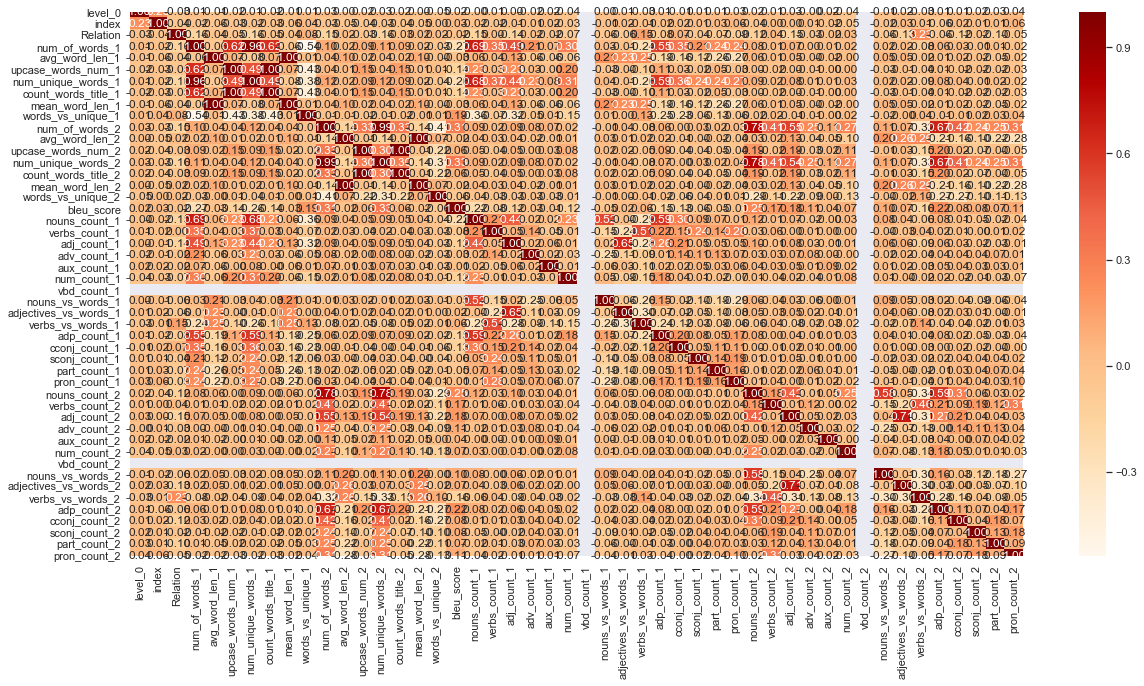

In [57]:
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='OrRd')

In [58]:
df.drop(columns=['index', 'level_0', \
                 'num_unique_words_1', 'upcase_words_num_1', 'avg_word_len_1', 'nouns_count_1', 'adj_count_1', 'vbd_count_1', \
                 'num_unique_words_2', 'upcase_words_num_2', 'avg_word_len_2', 'nouns_count_2', 'adj_count_2', 'vbd_count_2'], inplace=True)

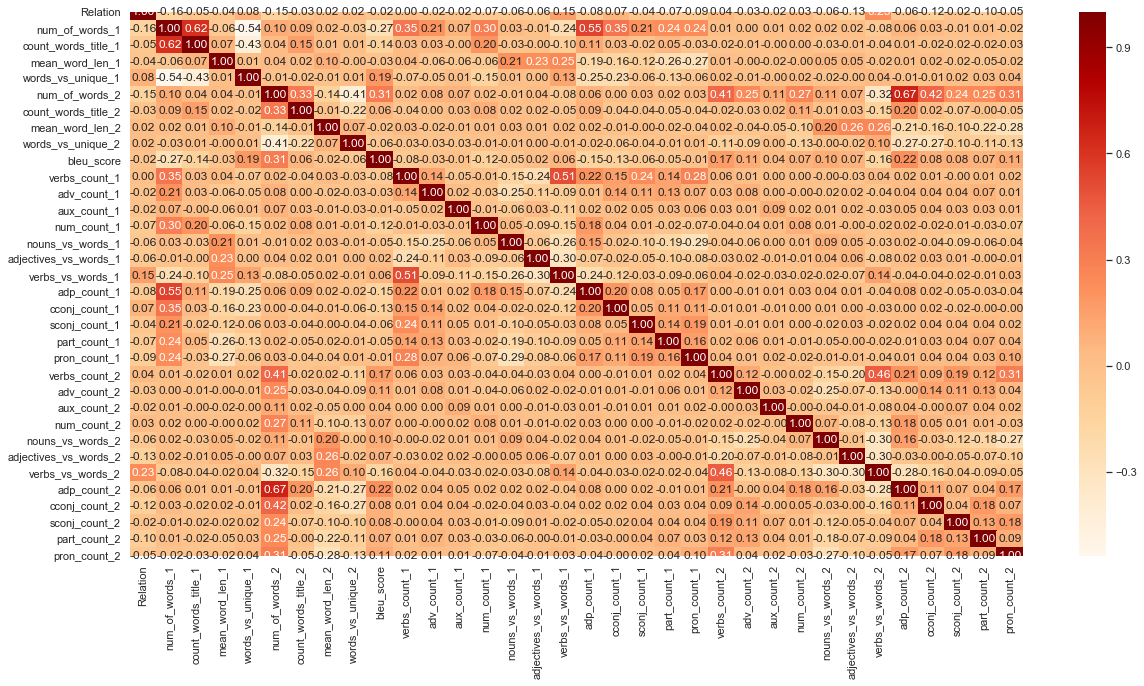

In [59]:
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='OrRd')

In [60]:
X = df.drop(columns=['Relation'])
y = df.Relation

In [61]:
X

,num_of_words_1,count_words_title_1,mean_word_len_1,words_vs_unique_1,num_of_words_2,count_words_title_2,mean_word_len_2,words_vs_unique_2,bleu_score,verbs_count_1,...,aux_count_2,num_count_2,nouns_vs_words_2,adjectives_vs_words_2,verbs_vs_words_2,adp_count_2,cconj_count_2,sconj_count_2,part_count_2,pron_count_2
2,-0.37,-0.33,0.52,0.22,1.01,0.93,-0.82,-2.81,0.53,1.29,...,-0.22,1.84,-0.60,-0.08,-0.55,3.18,-0.50,-0.36,-0.48,-0.70
3,-0.54,0.02,-0.05,0.22,1.01,0.93,-0.82,-2.81,0.19,-1.27,...,-0.22,1.84,-0.60,-0.08,-0.55,3.18,-0.50,-0.36,-0.48,-0.70
7,-0.02,0.02,-0.74,0.22,-0.97,-1.02,0.27,0.23,-0.73,0.01,...,-0.22,-0.36,-1.59,-0.73,3.04,-0.90,-0.50,-0.36,-0.48,0.66
8,2.22,2.13,-1.15,-2.26,-0.09,-0.05,-0.78,0.23,-1.62,-1.27,...,-0.22,1.84,0.10,0.39,-0.18,0.12,-0.50,-0.36,-0.48,0.66
10,-0.71,0.02,-0.33,0.22,0.13,1.91,-1.17,0.23,-0.75,-1.27,...,-0.22,-0.36,-0.11,0.25,-1.06,-0.90,-0.50,2.54,-0.48,0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11724,-0.37,-0.33,-0.01,0.22,0.35,1.91,0.05,0.23,0.47,0.01,...,-0.22,-0.36,0.39,-0.73,-0.38,1.14,-0.50,-0.36,-0.48,-0.70
11726,-0.71,-0.33,1.46,0.22,-0.53,-1.02,-0.08,0.23,0.50,0.01,...,-0.22,-0.36,-0.41,0.83,0.17,0.12,-0.50,-0.36,-0.48,0.66
11733,-0.37,-0.33,2.54,0.22,0.13,-0.05,1.84,0.23,0.67,0.01,...,-0.22,-0.36,-0.11,0.25,0.48,-0.90,-0.50,2.54,1.32,-0.70
11734,0.32,-0.33,0.27,0.22,-0.53,-1.02,2.39,0.23,0.52,0.01,...,-0.22,-0.36,0.78,0.83,0.17,-0.90,-0.50,-0.36,-0.48,-0.70


In [62]:
y

2        1
3        1
7        0
8        0
10       1
        ..
11724    0
11726    0
11733    0
11734    0
11735    0
Name: Relation, Length: 3804, dtype: int64

# Classification

In [63]:
kf = KFold(n_splits=5, shuffle=True, random_state=2020)

def train_and_verify(model, **kwargs):
    scores = []
    feature_weights = []

    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]

        model.fit(X_train, y_train, **kwargs)
        y_pred = model.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))

        if hasattr(model, 'feature_importances_'):
            feature_weights.append(pd.Series(model.feature_importances_, index=X_train.columns))

    clear_output(wait=True)

    print(f'Mean from scores: {np.mean(scores):.2f}')
    print(f'Std from scores: {np.std(scores):.2f}')

    print(classification_report(y_test, y_pred))

    return scores, feature_weights

# Decision Tree Classifier 

In [64]:
dt_cls = DecisionTreeClassifier(max_depth=7)
scores, feature_weights = train_and_verify(dt_cls)

print(scores)
print(feature_weights[np.array(scores).argmax()].sort_values(ascending=False))

Mean from scores: 0.61
Std from scores: 0.01
              precision    recall  f1-score   support

           0       0.62      0.90      0.73       424
           1       0.53      0.13      0.21       195
           2       0.55      0.38      0.45       141

    accuracy                           0.61       760
   macro avg       0.57      0.47      0.46       760
weighted avg       0.58      0.61      0.55       760

[0.6162943495400789, 0.6346911957950065, 0.6057818659658344, 0.6005256241787122, 0.6052631578947368]
verbs_vs_words_2        0.13
verbs_vs_words_1        0.10
num_of_words_1          0.09
cconj_count_1           0.09
adjectives_vs_words_1   0.08
bleu_score              0.05
nouns_vs_words_1        0.05
mean_word_len_1         0.04
verbs_count_1           0.04
verbs_count_2           0.04
mean_word_len_2         0.04
num_of_words_2          0.04
count_words_title_1     0.03
nouns_vs_words_2        0.03
part_count_1            0.02
adjectives_vs_words_2   0.02
part_coun

In [65]:
predicted = dt_cls.predict(X)
cm = confusion_matrix(y, predicted)

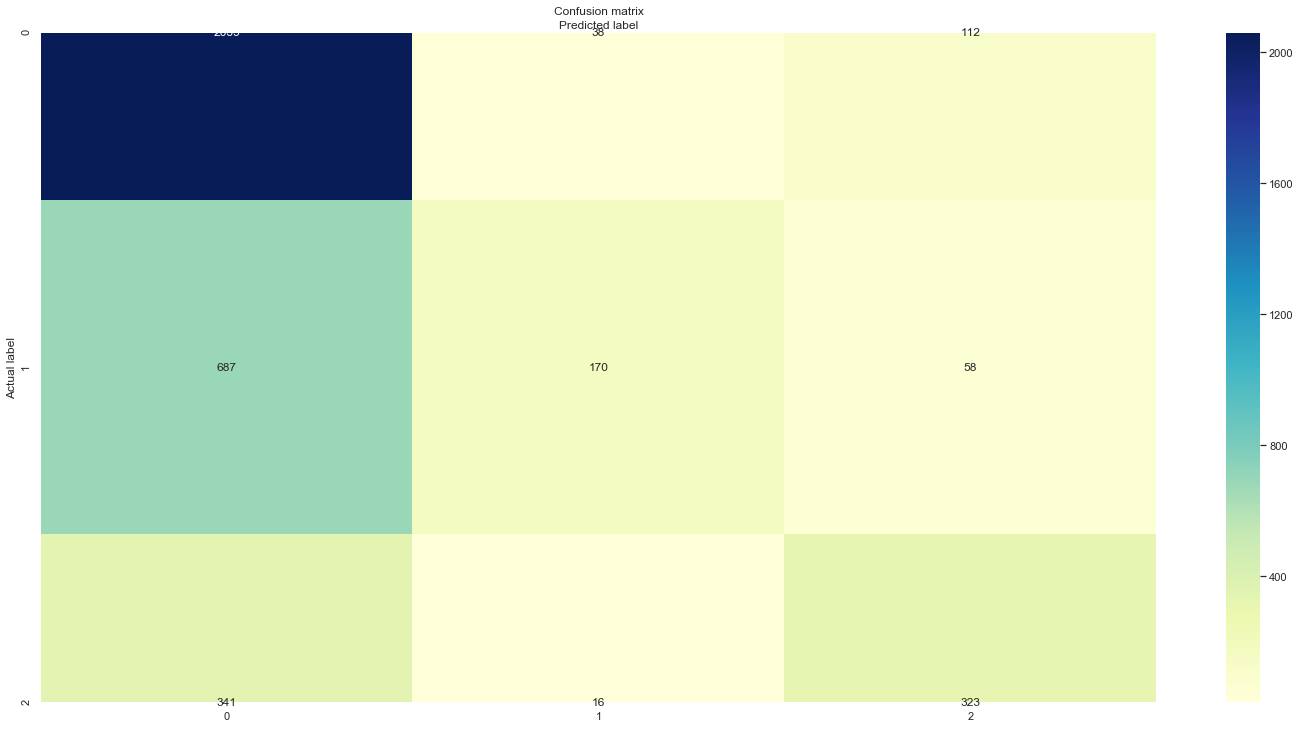

In [66]:
names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [67]:
pickle.dump(dt_cls, open('classifiers/dt_cls.pkl', 'wb'))

# SVM

In [68]:
svm_cls = SVC(kernel='linear')
train_and_verify(svm_cls)

Mean from scores: 0.61
Std from scores: 0.01
              precision    recall  f1-score   support

           0       0.59      0.97      0.73       424
           1       0.00      0.00      0.00       195
           2       0.71      0.33      0.45       141

    accuracy                           0.60       760
   macro avg       0.43      0.43      0.39       760
weighted avg       0.46      0.60      0.49       760



([0.6176084099868594,
  0.6228646517739816,
  0.6057818659658344,
  0.6189224704336399,
  0.6013157894736842],
 [])

In [69]:
predicted = svm_cls.predict(X)
cm = confusion_matrix(y, predicted)

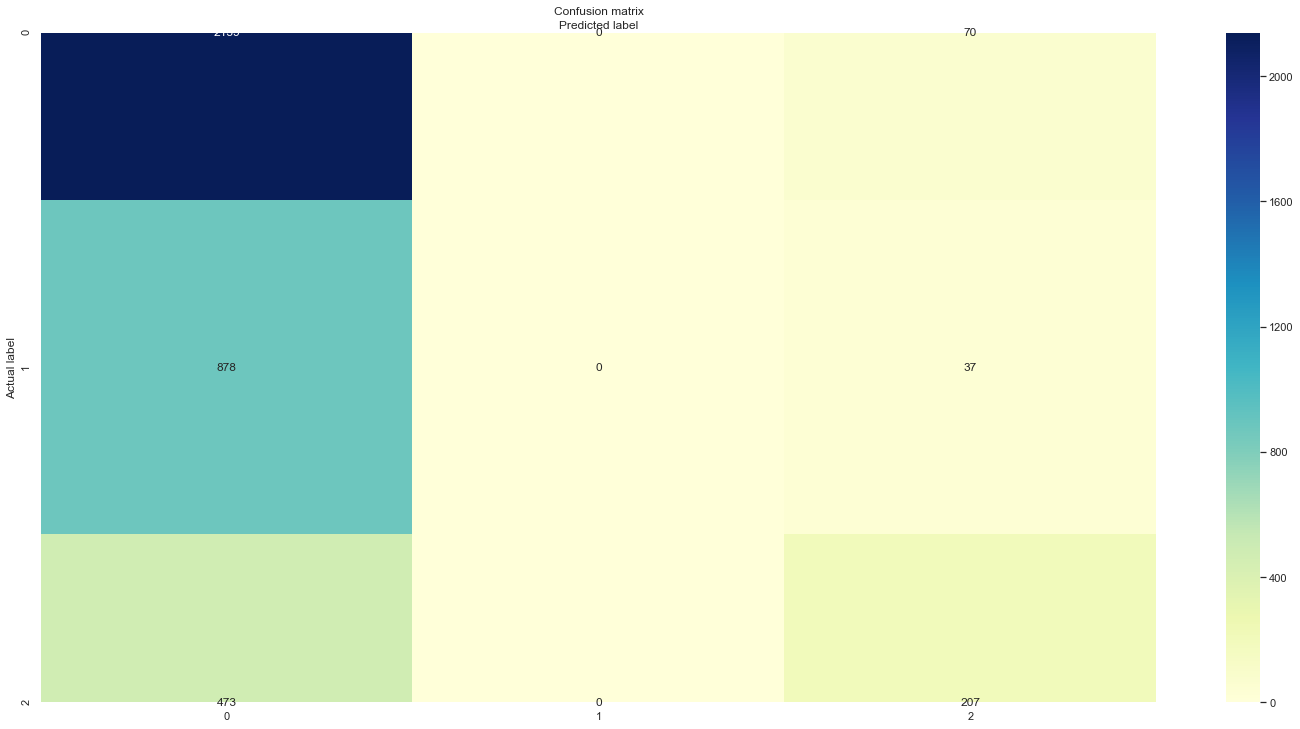

In [70]:
names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [71]:
pickle.dump(svm_cls, open('classifiers/svm_cls.pkl', 'wb'))

# Gaussian Naive Bayes

In [72]:
gnb_cls = GaussianNB()
train_and_verify(gnb_cls)

Mean from scores: 0.39
Std from scores: 0.01
              precision    recall  f1-score   support

           0       0.70      0.20      0.32       424
           1       0.34      0.58      0.43       195
           2       0.32      0.68      0.43       141

    accuracy                           0.39       760
   macro avg       0.45      0.49      0.39       760
weighted avg       0.54      0.39      0.37       760



([0.4021024967148489,
  0.3955321944809461,
  0.38370565045992117,
  0.40341655716162944,
  0.3894736842105263],
 [])

In [73]:
predicted = gnb_cls.predict(X)
cm = confusion_matrix(y, predicted)

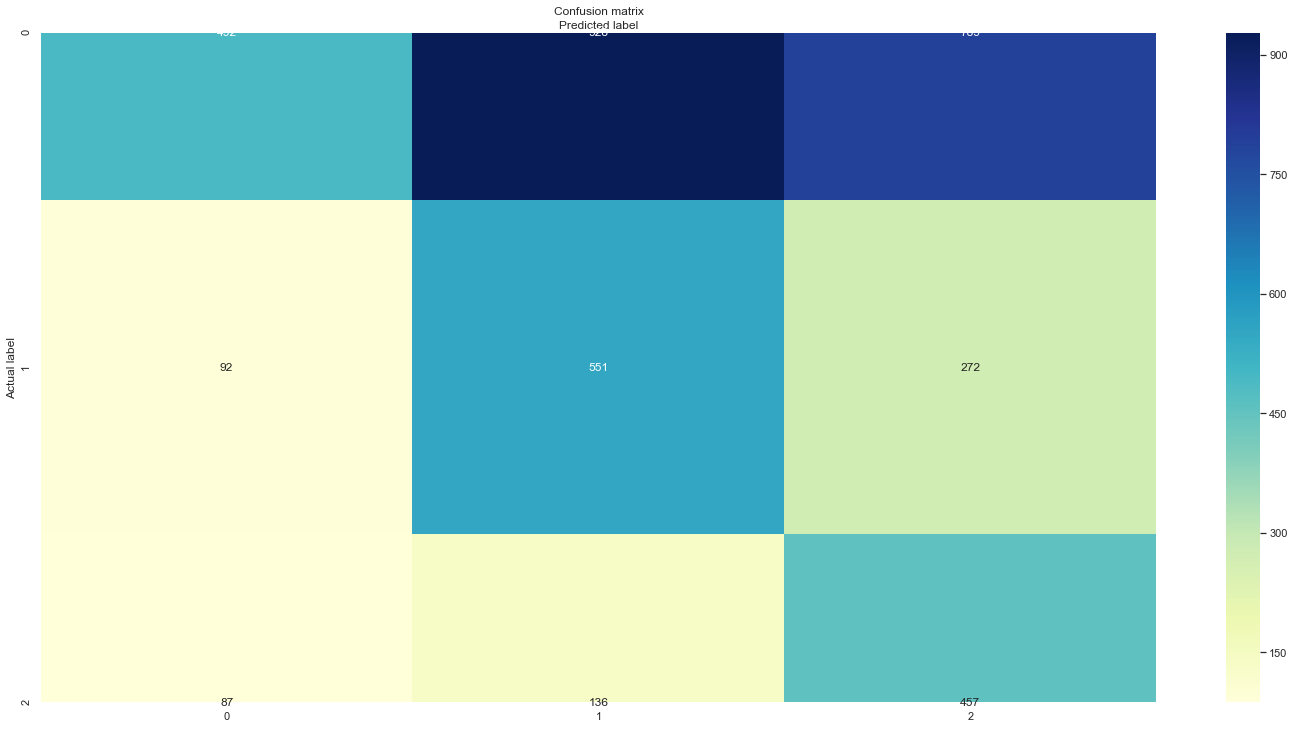

In [74]:
names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [75]:
pickle.dump(gnb_cls, open('classifiers/gnb_cls.pkl', 'wb'))

# Random Forest Classifier

In [76]:
randf_cls = RandomForestClassifier(random_state=2020)
scores, feature_weights = train_and_verify(randf_cls)

print(scores)
print(feature_weights[np.array(scores).argmax()].sort_values(ascending=False))

Mean from scores: 0.66
Std from scores: 0.01
              precision    recall  f1-score   support

           0       0.65      0.88      0.75       424
           1       0.53      0.28      0.37       195
           2       0.73      0.42      0.53       141

    accuracy                           0.64       760
   macro avg       0.64      0.53      0.55       760
weighted avg       0.63      0.64      0.61       760

[0.6596583442838371, 0.6754270696452037, 0.6491458607095927, 0.6504599211563732, 0.6407894736842106]
bleu_score              0.08
mean_word_len_2         0.08
mean_word_len_1         0.07
nouns_vs_words_1        0.06
num_of_words_1          0.05
nouns_vs_words_2        0.05
verbs_vs_words_2        0.05
num_of_words_2          0.05
verbs_vs_words_1        0.05
adjectives_vs_words_2   0.04
adjectives_vs_words_1   0.03
count_words_title_1     0.03
adv_count_1             0.03
count_words_title_2     0.03
pron_count_1            0.02
pron_count_2            0.02
cconj_cou

In [77]:
predicted = randf_cls.predict(X)
cm = confusion_matrix(y, predicted)

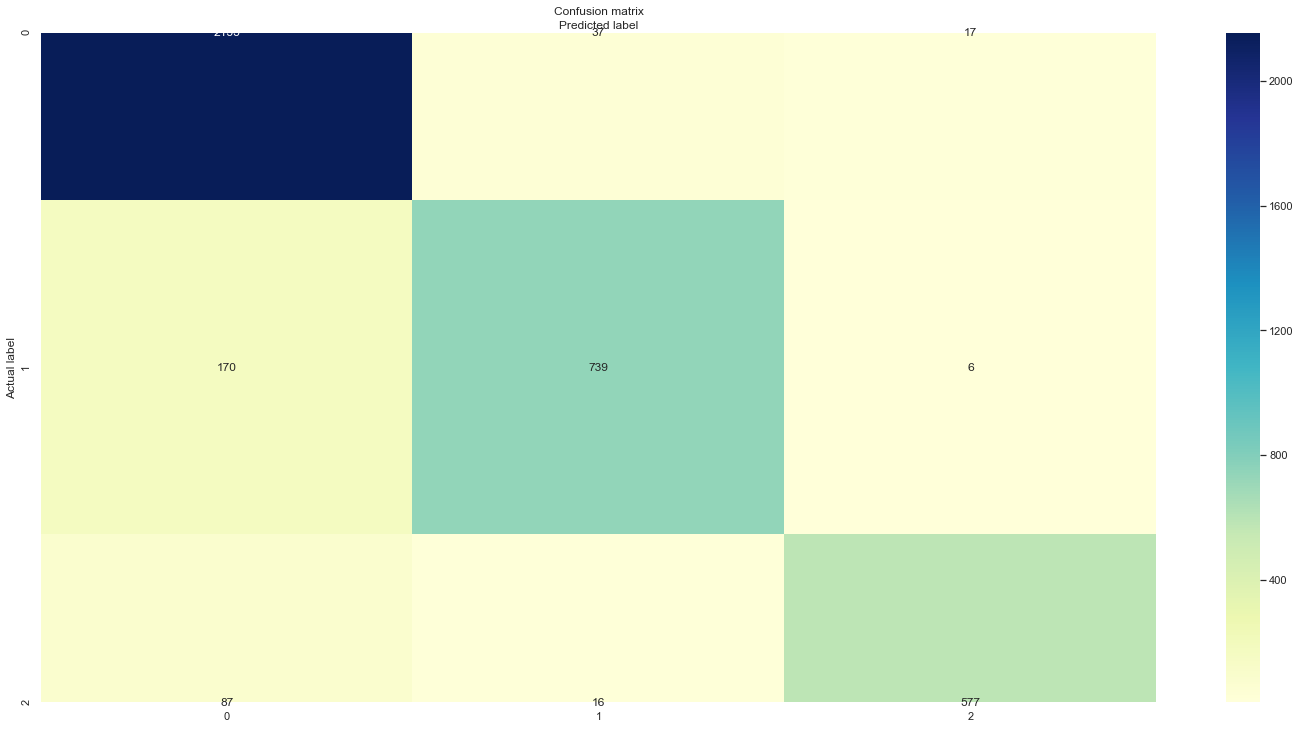

In [78]:
names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [79]:
pickle.dump(randf_cls, open('classifiers/randf_cls.pkl', 'wb'))

# Catboost

In [80]:
catboost_cls = CatBoostClassifier()
scores, feature_weights = train_and_verify(catboost_cls, verbose=False, plot=True)

print(scores)
print(feature_weights[np.array(scores).argmax()].sort_values(ascending=False))

Mean from scores: 0.68
Std from scores: 0.01
              precision    recall  f1-score   support

           0       0.68      0.87      0.76       424
           1       0.55      0.33      0.41       195
           2       0.78      0.55      0.65       141

    accuracy                           0.67       760
   macro avg       0.67      0.58      0.61       760
weighted avg       0.66      0.67      0.65       760

[0.6662286465177398, 0.6964520367936925, 0.6806833114323259, 0.6649145860709592, 0.6710526315789473]
mean_word_len_2         8.11
mean_word_len_1         8.06
bleu_score              7.45
verbs_vs_words_2        6.65
nouns_vs_words_2        6.43
verbs_vs_words_1        6.15
nouns_vs_words_1        6.08
num_of_words_1          4.54
adjectives_vs_words_2   4.41
adjectives_vs_words_1   4.01
num_of_words_2          3.49
pron_count_1            3.34
count_words_title_1     3.08
cconj_count_1           2.60
count_words_title_2     2.57
adv_count_1             2.50
adv_count

In [81]:
predicted = catboost_cls.predict(X)
cm = confusion_matrix(y, predicted)

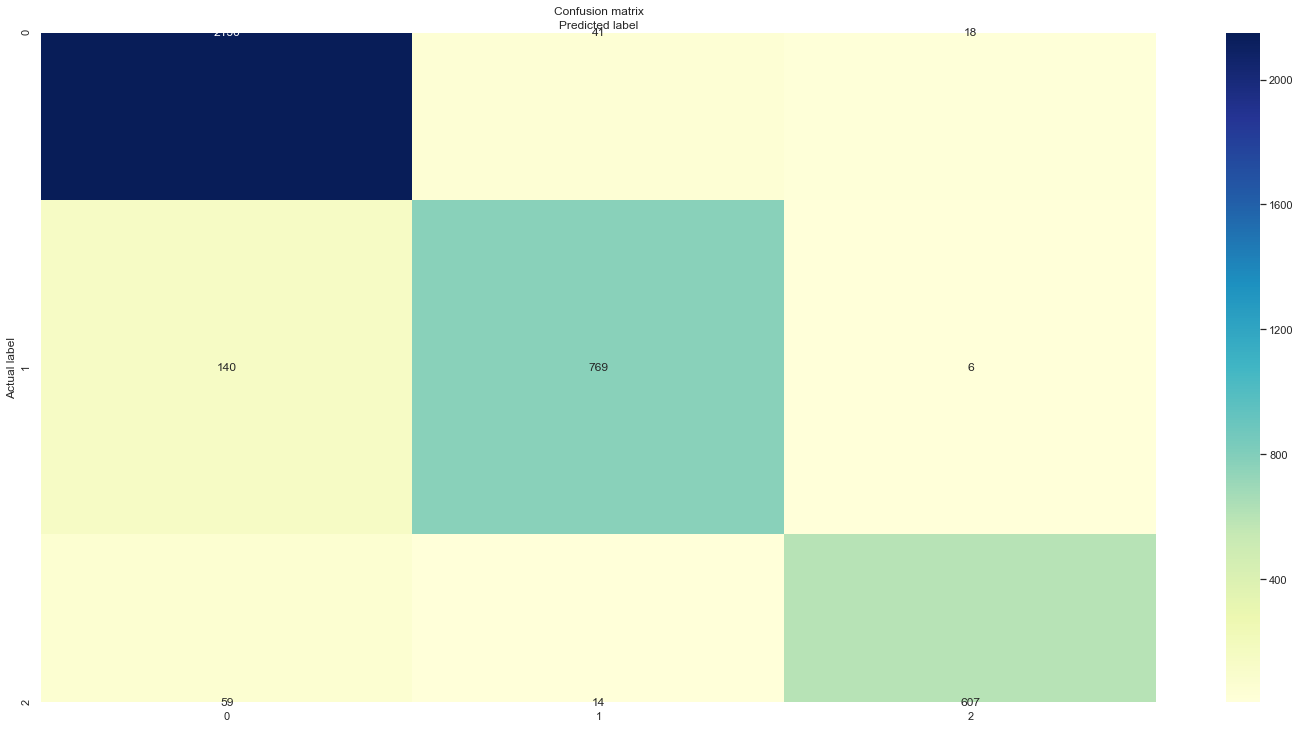

In [82]:
names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [83]:
pickle.dump(catboost_cls, open('classifiers/catboost_cls.pkl', 'wb'))

# Voting with Catboost, Random Forest and Decision tree

In [84]:
vote_cls = VotingClassifier(estimators=[
    ('randf', randf_cls), ('catboost', catboost_cls), ('dt', dt_cls)], voting='soft', weights=[2,2,1])
scores, feature_weights = train_and_verify(vote_cls)

print(scores)

Mean from scores: 0.68
Std from scores: 0.01
              precision    recall  f1-score   support

           0       0.66      0.92      0.77       424
           1       0.60      0.27      0.37       195
           2       0.84      0.52      0.64       141

    accuracy                           0.68       760
   macro avg       0.70      0.57      0.59       760
weighted avg       0.68      0.68      0.64       760

[0.683311432325887, 0.6911957950065704, 0.6898817345597897, 0.668856767411301, 0.6763157894736842]


In [85]:
predicted = vote_cls.predict(X)
cm = confusion_matrix(y, predicted)

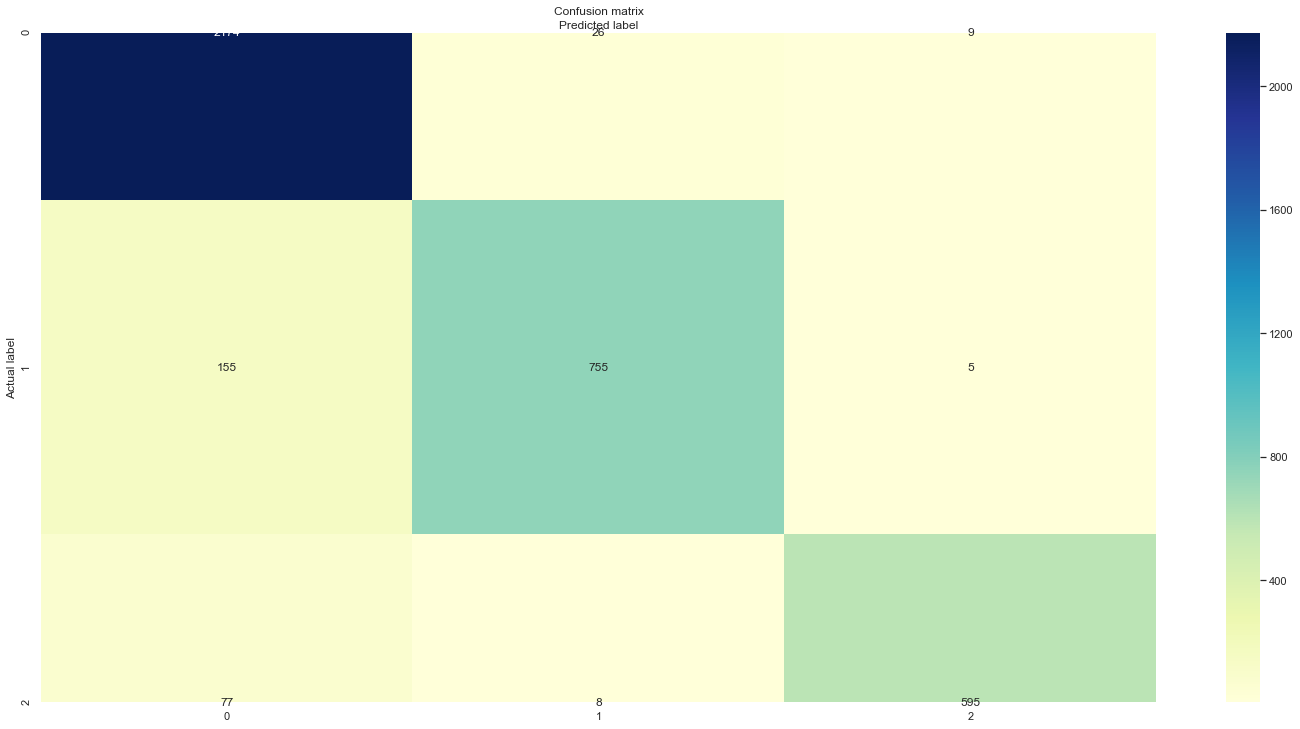

In [86]:
names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [87]:
pickle.dump(vote_cls, open('classifiers/vote_cls.pkl', 'wb'))

# Classification on schizo dataset

In [88]:
schizo_processed_dir = base_dir + 'data/schizo/schizo/processed/'
schizo_healthy_processed_dir = base_dir + 'data/schizo/healthy/processed/'

df_healthy = get_df_from_csvs_in_path(schizo_processed_dir)
df_schizo = get_df_from_csvs_in_path(schizo_healthy_processed_dir)

df_healthy.dropna(inplace=True)
df_schizo.dropna(inplace=True)

In [89]:
df_healthy

,EDU_1,EDU_2,Relation
0,где-нибудь в предгорьях на Кавказе,действие происходит где-нибудь на юге там,elaboration_r
1,либо в средней азии,действие происходит где-нибудь на юге там,contrast_m
2,который груши собирает,мужчина лет сорока пяти там,elaboration_r
3,взял лестницу,мужчина лет сорока пяти там,joint_m
4,по лестнице на дерево там,мужчина лет сорока пяти там,elaboration_r
...,...,...,...
309,ты что-то забыл,и потом они ему свистят,sequence_m
310,типа,и потом они ему свистят,evaluation_r
311,и потом дают ему,груши собирает,sequence_m
312,что он забыл,и потом дают ему,contrast_m


In [90]:
df_schizo

,EDU_1,EDU_2,Relation
0,ну я б сказала,не очень правдоподобная история,evaluation_r
1,не очень правдоподобная история,человек собирает груши,preparation_r
2,потому что этот человек,не очень правдоподобная история,cause_r
3,убирающий собирающий груши,потому что этот человек,elaboration_r
4,наверняка он все-таки звук слышит хорошо,потому что этот человек,joint_m
...,...,...,...
544,он их за это угостил грушами вот,но это самое а шляпа-то у него улетела тоже,circumstance_r
545,это то есть мальчик такой ну благодарный,вот поехал дальше,antithesis_r
546,будем говорить да,это то есть мальчик такой ну благодарный,evaluation_r
547,вот ну и в общем повёз это всё домой помощник,вот поехал дальше,sequence_m


In [91]:
def get_stats(target_df):
    internal_df = target_df[target_df.columns.intersection(['EDU_1', 'EDU_2'], sort=False)].copy()
    
    internal_df['edu_len_1'] = internal_df['EDU_1'].apply(lambda x: len(x))
    internal_df['sconj_vs_words_1'] = target_df['sconj_count_1'] / target_df['num_of_words_1']
    internal_df['cconj_vs_words_1'] = target_df['cconj_count_1'] / target_df['num_of_words_1']
    internal_df['adp_vs_words_1'] = target_df['adp_count_1'] / target_df['num_of_words_1']
    internal_df['part_vs_words_1'] = target_df['part_count_1'] / target_df['num_of_words_1']
    internal_df['aux_vs_words_1'] = target_df['aux_count_1'] / target_df['num_of_words_1']

    internal_df['edu_len_2'] = internal_df['EDU_2'].apply(lambda x: len(x))
    internal_df['sconj_vs_words_2'] = target_df['sconj_count_2'] / target_df['num_of_words_2']
    internal_df['cconj_vs_words_2'] = target_df['cconj_count_2'] / target_df['num_of_words_2']
    internal_df['adp_vs_words_2'] = target_df['adp_count_2'] / target_df['num_of_words_2']
    internal_df['part_vs_words_2'] = target_df['part_count_2'] / target_df['num_of_words_2']
    internal_df['aux_vs_words_2'] = target_df['aux_count_2'] / target_df['num_of_words_2']

    return internal_df.describe()

In [92]:
# df_healthy = extract_features(df_healthy)
# extract_from_deeppavlov(df_healthy.reset_index(), 'heathy', 1)

In [93]:
df_healthy = pd.read_csv('./data/schizo/healthy/deeppavlov_features_heathy.csv', header=0, sep='\t')
df_healthy

,index,EDU_1,EDU_2,Relation,num_of_words_1,avg_word_len_1,upcase_words_num_1,num_unique_words_1,count_words_title_1,mean_word_len_1,...,num_count_2,vbd_count_2,nouns_vs_words_2,adjectives_vs_words_2,verbs_vs_words_2,adp_count_2,cconj_count_2,sconj_count_2,part_count_2,pron_count_2
0,0,где-нибудь в предгорьях на Кавказе,действие происходит где-нибудь на юге там,elaboration_r,5,6.00,1,5,1,6.00,...,0,0,0.33,0.00,0.17,1,0,0,0,0
1,1,либо в средней азии,действие происходит где-нибудь на юге там,contrast_m,4,4.00,0,4,0,4.00,...,0,0,0.33,0.00,0.17,1,0,0,0,0
2,2,который груши собирает,мужчина лет сорока пяти там,elaboration_r,3,6.67,0,3,0,6.67,...,2,0,0.40,0.00,0.00,0,0,0,0,0
3,3,взял лестницу,мужчина лет сорока пяти там,joint_m,2,6.00,0,2,0,6.00,...,2,0,0.40,0.00,0.00,0,0,0,0,0
4,4,по лестнице на дерево там,мужчина лет сорока пяти там,elaboration_r,5,4.20,0,5,0,4.20,...,2,0,0.40,0.00,0.00,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,309,ты что-то забыл,и потом они ему свистят,sequence_m,3,4.33,0,3,0,4.33,...,0,0,0.00,0.00,0.20,0,1,0,0,2
310,310,типа,и потом они ему свистят,evaluation_r,1,4.00,0,1,0,4.00,...,0,0,0.00,0.00,0.20,0,1,0,0,2
311,311,и потом дают ему,груши собирает,sequence_m,4,3.25,0,4,0,3.25,...,0,0,0.50,0.00,0.50,0,0,0,0,0
312,312,что он забыл,и потом дают ему,contrast_m,3,3.33,0,3,0,3.33,...,0,0,0.00,0.00,0.25,0,1,0,0,1


In [94]:
df_healthy_stats = get_stats(df_healthy)
df_healthy_stats

,edu_len_1,sconj_vs_words_1,cconj_vs_words_1,adp_vs_words_1,part_vs_words_1,aux_vs_words_1,edu_len_2,sconj_vs_words_2,cconj_vs_words_2,adp_vs_words_2,part_vs_words_2,aux_vs_words_2
count,314.00,314.00,314.00,314.00,314.00,314.00,314.00,314.00,314.00,314.00,314.00,314.00
mean,21.99,0.01,0.06,0.08,0.06,0.00,25.72,0.02,0.05,0.09,0.03,0.00
std,10.61,0.06,0.12,0.12,0.16,0.02,12.69,0.06,0.12,0.11,0.10,0.01
min,2.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00
25%,15.00,0.00,0.00,0.00,0.00,0.00,16.00,0.00,0.00,0.00,0.00,0.00
50%,21.00,0.00,0.00,0.00,0.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00
75%,29.00,0.00,0.00,0.17,0.00,0.00,33.75,0.00,0.00,0.20,0.00,0.00
max,54.00,0.33,0.50,0.50,1.00,0.20,67.00,0.25,0.50,0.33,0.67,0.14


In [95]:
df_healthy = preprocess(df_healthy)
df_healthy

,index,Relation,num_of_words_1,avg_word_len_1,upcase_words_num_1,num_unique_words_1,count_words_title_1,mean_word_len_1,words_vs_unique_1,num_of_words_2,...,num_count_2,vbd_count_2,nouns_vs_words_2,adjectives_vs_words_2,verbs_vs_words_2,adp_count_2,cconj_count_2,sconj_count_2,part_count_2,pron_count_2
0,-1.72,0,0.54,0.74,13.96,0.58,13.96,0.74,0.16,0.48,...,-0.39,0.00,0.10,-0.32,-0.26,0.55,-0.43,-0.24,-0.26,-0.69
2,-1.69,0,-0.56,1.22,-0.07,-0.55,-0.07,1.22,0.16,0.07,...,1.87,0.00,0.44,-0.32,-1.29,-0.81,-0.43,-0.24,-0.26,-0.69
4,-1.67,0,0.54,-0.55,-0.07,0.58,-0.07,-0.55,0.16,0.07,...,1.87,0.00,0.44,-0.32,-1.29,-0.81,-0.43,-0.24,-0.26,-0.69
8,-1.63,2,-0.01,-0.87,-0.07,0.02,-0.07,-0.87,0.16,0.07,...,1.87,0.00,0.44,-0.32,-1.29,-0.81,-0.43,-0.24,-0.26,-0.69
10,-1.61,2,0.54,-0.26,-0.07,0.58,-0.07,-0.26,0.16,-0.34,...,-0.39,0.00,-1.62,-0.32,0.25,-0.81,-0.43,-0.24,2.76,-0.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,1.58,2,0.54,-0.83,-0.07,0.58,-0.07,-0.83,0.16,-1.17,...,-0.39,0.00,0.96,-0.32,1.79,-0.81,-0.43,-0.24,-0.26,-0.69
309,1.60,2,-0.56,-0.45,-0.07,-0.55,-0.07,-0.45,0.16,0.07,...,-0.39,0.00,-1.62,-0.32,-0.06,-0.81,2.31,-0.24,-0.26,3.14
310,1.61,1,-1.66,-0.69,-0.07,-1.67,-0.07,-0.69,0.16,0.07,...,-0.39,0.00,-1.62,-0.32,-0.06,-0.81,2.31,-0.24,-0.26,3.14
311,1.62,2,-0.01,-1.22,-0.07,0.02,-0.07,-1.22,0.16,-1.17,...,-0.39,0.00,0.96,-0.32,1.79,-0.81,-0.43,-0.24,-0.26,-0.69


In [96]:
df_healthy.drop(columns=['index', 'num_unique_words_1', 'upcase_words_num_1', 'avg_word_len_1', \
                         'nouns_count_1', 'adj_count_1', 'vbd_count_1', 'num_unique_words_2', 'upcase_words_num_2', \
                         'avg_word_len_2', 'nouns_count_2', 'adj_count_2', 'vbd_count_2'], inplace=True)

In [97]:
# df_schizo = extract_features(df_schizo)
# extract_from_deeppavlov(df_schizo.reset_index(), 'schizo', 1)

In [98]:
df_schizo = pd.read_csv('./data/schizo/schizo/deeppavlov_features_schizo.csv', header=0, sep='\t')
df_schizo

,index,EDU_1,EDU_2,Relation,num_of_words_1,avg_word_len_1,upcase_words_num_1,num_unique_words_1,count_words_title_1,mean_word_len_1,...,num_count_2,vbd_count_2,nouns_vs_words_2,adjectives_vs_words_2,verbs_vs_words_2,adp_count_2,cconj_count_2,sconj_count_2,part_count_2,pron_count_2
0,0,ну я б сказала,не очень правдоподобная история,evaluation_r,4,2.75,0,4,0,2.75,...,0,0,0.25,0.25,0.00,0,0,0,1,0
1,1,не очень правдоподобная история,человек собирает груши,preparation_r,4,7.00,0,4,0,7.00,...,0,0,0.67,0.00,0.33,0,0,0,0,0
2,2,потому что этот человек,не очень правдоподобная история,cause_r,4,5.00,0,4,0,5.00,...,0,0,0.25,0.25,0.00,0,0,0,1,0
3,3,убирающий собирающий груши,потому что этот человек,elaboration_r,3,8.00,0,3,0,8.00,...,0,0,0.25,0.00,0.00,0,0,1,0,0
4,4,наверняка он все-таки звук слышит хорошо,потому что этот человек,joint_m,6,5.83,0,6,0,5.83,...,0,0,0.25,0.00,0.00,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,544,он их за это угостил грушами вот,но это самое а шляпа-то у него улетела тоже,circumstance_r,7,3.71,0,7,0,3.71,...,0,0,0.00,0.11,0.11,1,2,0,2,2
545,545,это то есть мальчик такой ну благодарный,вот поехал дальше,antithesis_r,7,4.86,0,7,0,4.86,...,0,0,0.00,0.00,0.33,0,0,0,1,0
546,546,будем говорить да,это то есть мальчик такой ну благодарный,evaluation_r,3,5.00,0,3,0,5.00,...,0,0,0.14,0.14,0.14,0,0,0,1,2
547,547,вот ну и в общем повёз это всё домой помощник,вот поехал дальше,sequence_m,10,3.60,0,10,0,3.60,...,0,0,0.00,0.00,0.33,0,0,0,1,0


In [99]:
df_schizo_stats = get_stats(df_schizo)
df_schizo_stats

,edu_len_1,sconj_vs_words_1,cconj_vs_words_1,adp_vs_words_1,part_vs_words_1,aux_vs_words_1,edu_len_2,sconj_vs_words_2,cconj_vs_words_2,adp_vs_words_2,part_vs_words_2,aux_vs_words_2
count,549.00,549.00,549.00,549.00,549.00,549.00,549.00,549.00,549.00,549.00,549.00,549.00
mean,25.07,0.03,0.07,0.06,0.08,0.00,28.02,0.03,0.06,0.07,0.07,0.00
std,13.42,0.08,0.13,0.10,0.14,0.03,16.71,0.08,0.12,0.09,0.13,0.03
min,3.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00
25%,15.00,0.00,0.00,0.00,0.00,0.00,17.00,0.00,0.00,0.00,0.00,0.00
50%,23.00,0.00,0.00,0.00,0.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00
75%,32.00,0.00,0.12,0.12,0.14,0.00,35.00,0.00,0.11,0.14,0.14,0.00
max,86.00,0.50,0.50,0.50,0.67,0.33,83.00,0.50,0.50,0.33,1.00,0.25


In [100]:
df_schizo = preprocess(df_schizo)
df_schizo

,index,Relation,num_of_words_1,avg_word_len_1,upcase_words_num_1,num_unique_words_1,count_words_title_1,mean_word_len_1,words_vs_unique_1,num_of_words_2,...,num_count_2,vbd_count_2,nouns_vs_words_2,adjectives_vs_words_2,verbs_vs_words_2,adp_count_2,cconj_count_2,sconj_count_2,part_count_2,pron_count_2
0,-1.69,1,-0.18,-1.57,-0.06,-0.16,-0.06,-1.57,0.20,-0.37,...,-0.32,0.00,-0.02,4.16,-1.28,-0.69,-0.56,-0.42,0.85,-0.76
3,-1.67,0,-0.59,1.94,-0.06,-0.58,-0.06,1.94,0.20,-0.37,...,-0.32,0.00,-0.02,-0.29,-1.28,-0.69,-0.56,2.41,-0.57,-0.76
6,-1.65,1,1.03,-0.26,-0.06,1.10,-0.06,-0.26,0.20,-0.37,...,-0.32,0.00,-0.02,-0.29,-1.28,-0.69,-0.56,2.41,-0.57,-0.76
7,-1.64,1,1.03,-0.36,-0.06,1.10,-0.06,-0.36,0.20,-0.37,...,-0.32,0.00,-0.02,-0.29,-1.28,-0.69,-0.56,-0.42,0.85,0.64
10,-1.63,1,0.22,-0.60,-0.06,0.26,-0.06,-0.60,0.20,-0.37,...,-0.32,0.00,1.18,4.16,-1.28,0.76,-0.56,-0.42,-0.57,-0.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,1.68,2,1.03,-0.16,-0.06,1.10,-0.06,-0.16,0.20,1.21,...,-0.32,0.00,-1.21,1.69,-0.69,0.76,3.77,-0.42,2.27,2.05
543,1.69,2,-0.99,0.27,-0.06,-1.00,-0.06,0.27,0.20,1.21,...,-0.32,0.00,-1.21,1.69,-0.69,0.76,3.77,-0.42,2.27,2.05
546,1.71,1,-0.59,-0.07,-0.06,-0.58,-0.06,-0.07,0.20,0.58,...,-0.32,0.00,-0.53,2.25,-0.52,-0.69,-0.56,-0.42,0.85,2.05
547,1.71,2,2.25,-1.01,-0.06,2.37,-0.06,-1.01,0.20,-0.68,...,-0.32,0.00,-1.21,-0.29,0.50,-0.69,-0.56,-0.42,0.85,-0.76


In [101]:
df_schizo.drop(columns=['index', 'num_unique_words_1', 'upcase_words_num_1', 'avg_word_len_1', \
                        'nouns_count_1', 'adj_count_1', 'vbd_count_1', 'num_unique_words_2', 'upcase_words_num_2', \
                        'avg_word_len_2', 'nouns_count_2', 'adj_count_2', 'vbd_count_2'], inplace=True)

In [102]:
X_healthy = df_healthy.drop(columns=['Relation'])
y_healthy = df_healthy.Relation

In [103]:
X_schizo = df_schizo.drop(columns=['Relation'])
y_schizo = df_schizo.Relation

In [104]:
print(f"SVM healthy accuracy: {accuracy_score(y_healthy, svm_cls.predict(X_healthy))}")
print(f"Decision Tree Classifier healthy accuracy: {accuracy_score(y_healthy, dt_cls.predict(X_healthy))}")
print(f"Gaussian Naive Bayes healthy accuracy: {accuracy_score(y_healthy, gnb_cls.predict(X_healthy))}")
print(f"Random Forest healthy accuracy: {accuracy_score(y_healthy, randf_cls.predict(X_healthy))}")
print(f"Catboost healthy accuracy: {accuracy_score(y_healthy, catboost_cls.predict(X_healthy))}")
print(f"Voting healthy accuracy: {accuracy_score(y_healthy, vote_cls.predict(X_healthy))}")

SVM healthy accuracy: 0.1989795918367347
Decision Tree Classifier healthy accuracy: 0.19387755102040816
Gaussian Naive Bayes healthy accuracy: 0.4642857142857143
Random Forest healthy accuracy: 0.21428571428571427
Catboost healthy accuracy: 0.2193877551020408
Voting healthy accuracy: 0.1989795918367347


In [105]:
print(f"SVM schizo accuracy: {accuracy_score(y_schizo, svm_cls.predict(X_schizo))}")
print(f"Decision Tree Classifier schizo accuracy: {accuracy_score(y_schizo, dt_cls.predict(X_schizo))}")
print(f"Gaussian Naive Bayes schizo accuracy: {accuracy_score(y_schizo, gnb_cls.predict(X_schizo))}")
print(f"Random Forest schizo accuracy: {accuracy_score(y_schizo, randf_cls.predict(X_schizo))}")
print(f"Catboost schizo accuracy: {accuracy_score(y_schizo, catboost_cls.predict(X_schizo))}")
print(f"Catboost schizo accuracy: {accuracy_score(y_schizo, vote_cls.predict(X_schizo))}")

SVM schizo accuracy: 0.25263157894736843
Decision Tree Classifier schizo accuracy: 0.21403508771929824
Gaussian Naive Bayes schizo accuracy: 0.5368421052631579
Random Forest schizo accuracy: 0.24210526315789474
Catboost schizo accuracy: 0.256140350877193
Catboost schizo accuracy: 0.24210526315789474


In [106]:
gradeBool = (df_schizo_stats != df_healthy_stats).stack()
gradediff = pd.concat([df_schizo_stats.stack()[gradeBool],
						df_healthy_stats.stack()[gradeBool]], axis=1)
gradediff.columns=["schizo", "healthy"]
print(gradediff)

                        schizo  healthy
count edu_len_1         549.00   314.00
      sconj_vs_words_1  549.00   314.00
      cconj_vs_words_1  549.00   314.00
      adp_vs_words_1    549.00   314.00
      part_vs_words_1   549.00   314.00
      aux_vs_words_1    549.00   314.00
      edu_len_2         549.00   314.00
      sconj_vs_words_2  549.00   314.00
      cconj_vs_words_2  549.00   314.00
      adp_vs_words_2    549.00   314.00
      part_vs_words_2   549.00   314.00
      aux_vs_words_2    549.00   314.00
mean  edu_len_1          25.07    21.99
      sconj_vs_words_1    0.03     0.01
      cconj_vs_words_1    0.07     0.06
      adp_vs_words_1      0.06     0.08
      part_vs_words_1     0.08     0.06
      aux_vs_words_1      0.00     0.00
      edu_len_2          28.02    25.72
      sconj_vs_words_2    0.03     0.02
      cconj_vs_words_2    0.06     0.05
      adp_vs_words_2      0.07     0.09
      part_vs_words_2     0.07     0.03
      aux_vs_words_2      0.00     0.00


# Classification analysis

# Catboost

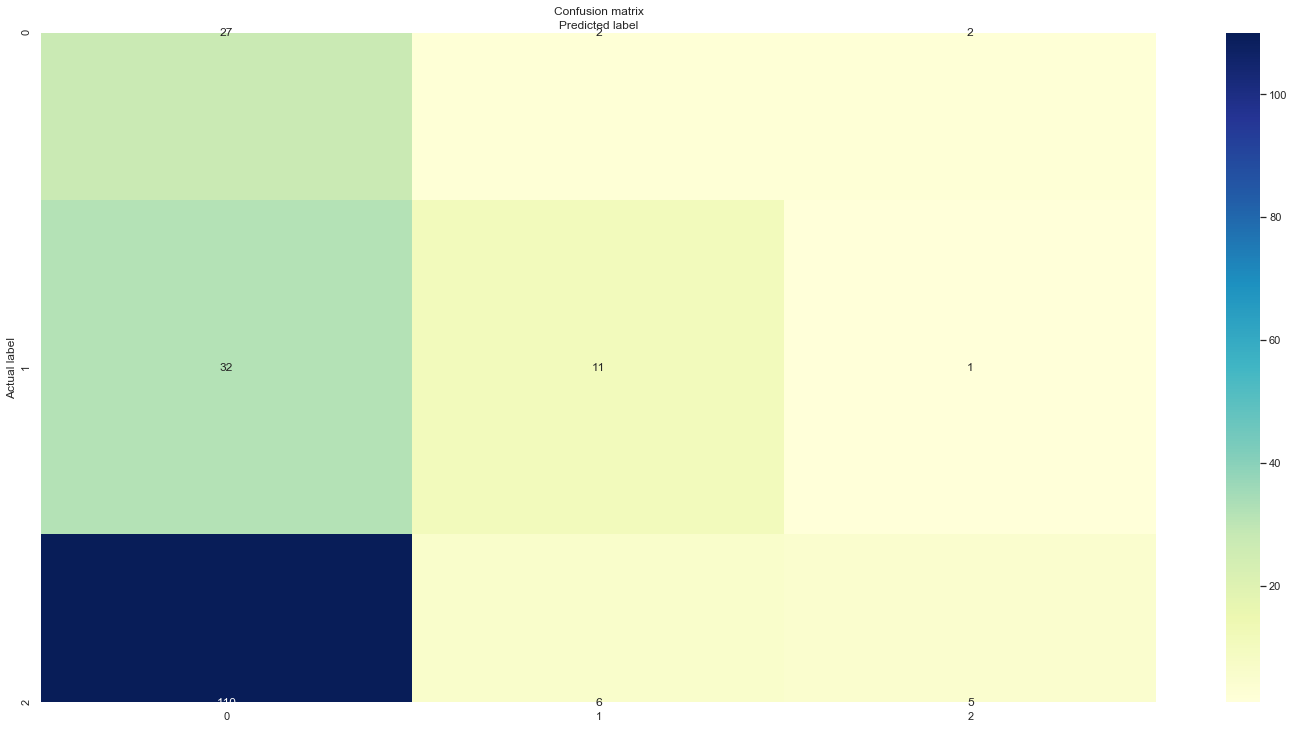

In [107]:
predicted = catboost_cls.predict(X_healthy)
cm = confusion_matrix(y_healthy, predicted)

names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [108]:
print(classification_report(y_healthy, predicted))

              precision    recall  f1-score   support

           0       0.16      0.87      0.27        31
           1       0.58      0.25      0.35        44
           2       0.62      0.04      0.08       121

    accuracy                           0.22       196
   macro avg       0.45      0.39      0.23       196
weighted avg       0.54      0.22      0.17       196



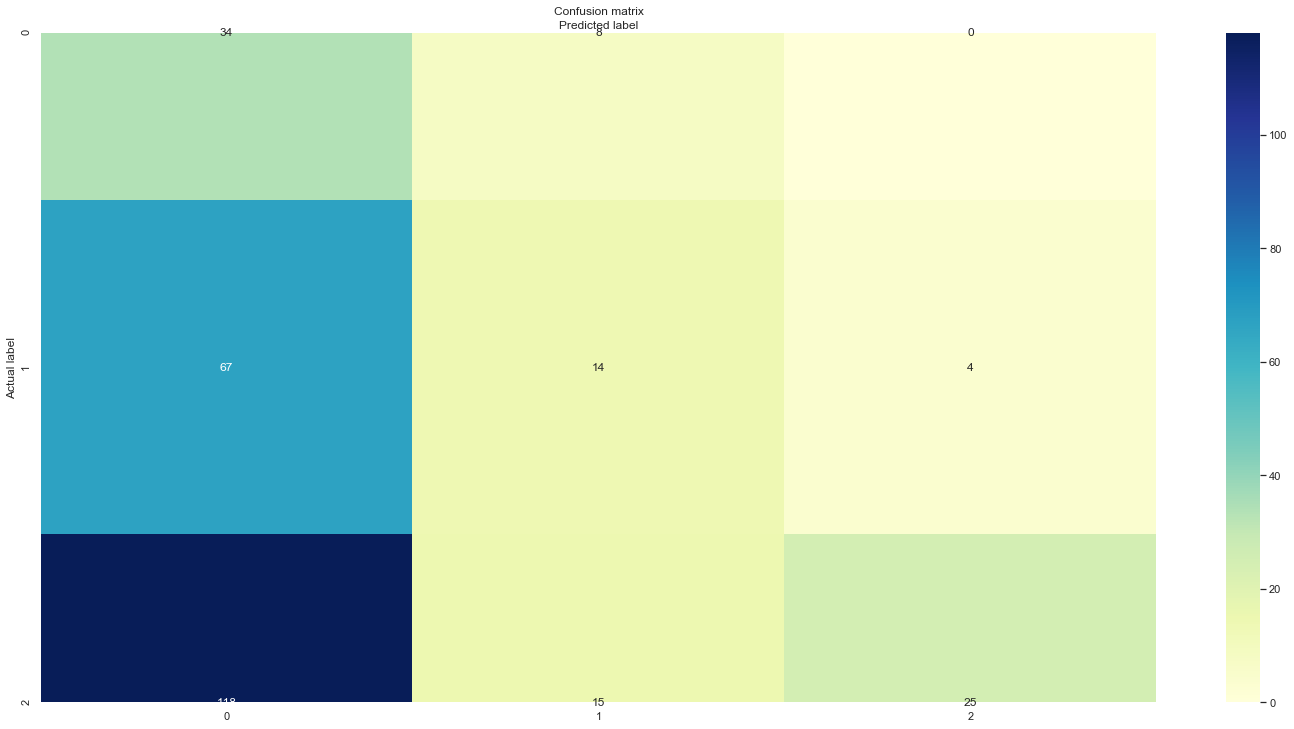

In [109]:
predicted = catboost_cls.predict(X_schizo)
cm = confusion_matrix(y_schizo, predicted)

names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [110]:
print(classification_report(y_schizo, predicted))

              precision    recall  f1-score   support

           0       0.16      0.81      0.26        42
           1       0.38      0.16      0.23        85
           2       0.86      0.16      0.27       158

    accuracy                           0.26       285
   macro avg       0.47      0.38      0.25       285
weighted avg       0.61      0.26      0.26       285



# Random Forest

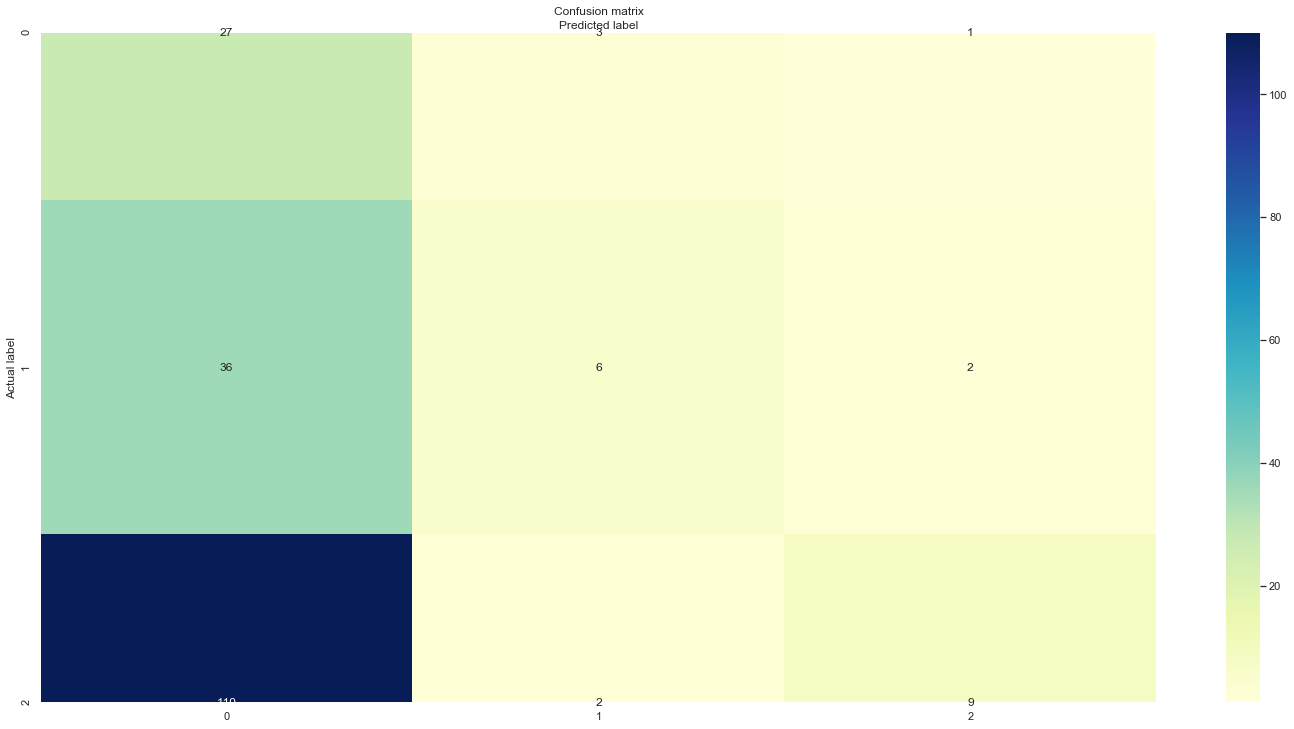

In [111]:
predicted = randf_cls.predict(X_healthy)
cm = confusion_matrix(y_healthy, predicted)

names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [112]:
print(classification_report(y_healthy, predicted))

              precision    recall  f1-score   support

           0       0.16      0.87      0.26        31
           1       0.55      0.14      0.22        44
           2       0.75      0.07      0.14       121

    accuracy                           0.21       196
   macro avg       0.48      0.36      0.21       196
weighted avg       0.61      0.21      0.17       196



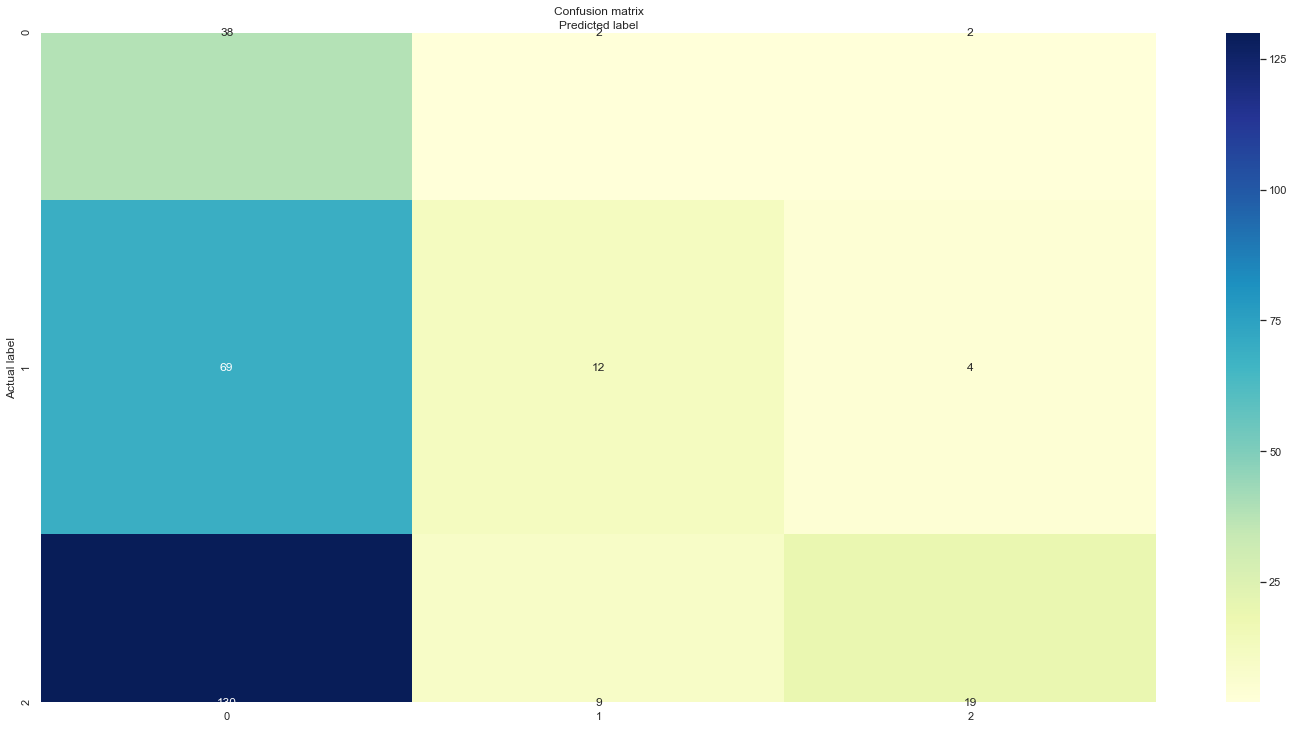

In [113]:
predicted = randf_cls.predict(X_schizo)
cm = confusion_matrix(y_schizo, predicted)

names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [114]:
print(classification_report(y_schizo, predicted))

              precision    recall  f1-score   support

           0       0.16      0.90      0.27        42
           1       0.52      0.14      0.22        85
           2       0.76      0.12      0.21       158

    accuracy                           0.24       285
   macro avg       0.48      0.39      0.23       285
weighted avg       0.60      0.24      0.22       285



# Voting with Catboost, Random Forest and Decision tree

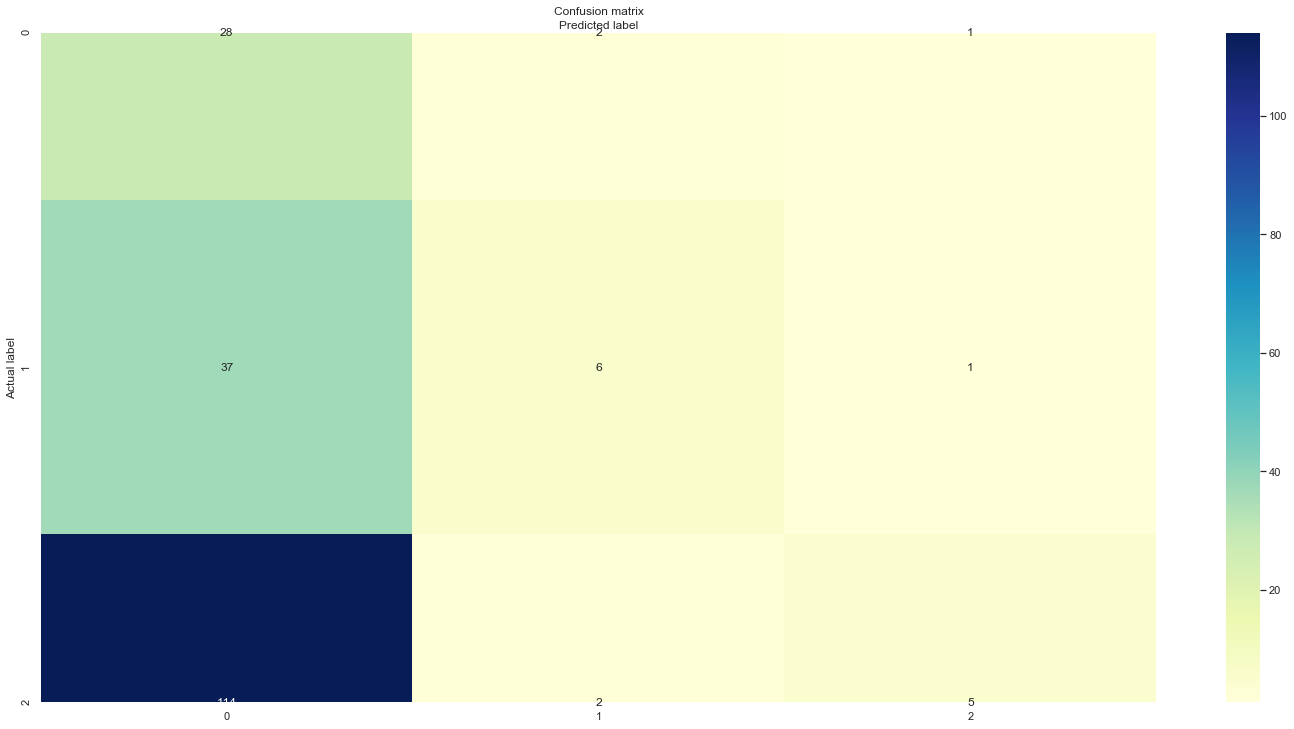

In [115]:
predicted = vote_cls.predict(X_healthy)
cm = confusion_matrix(y_healthy, predicted)

names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [116]:
print(classification_report(y_healthy, predicted))

              precision    recall  f1-score   support

           0       0.16      0.90      0.27        31
           1       0.60      0.14      0.22        44
           2       0.71      0.04      0.08       121

    accuracy                           0.20       196
   macro avg       0.49      0.36      0.19       196
weighted avg       0.60      0.20      0.14       196



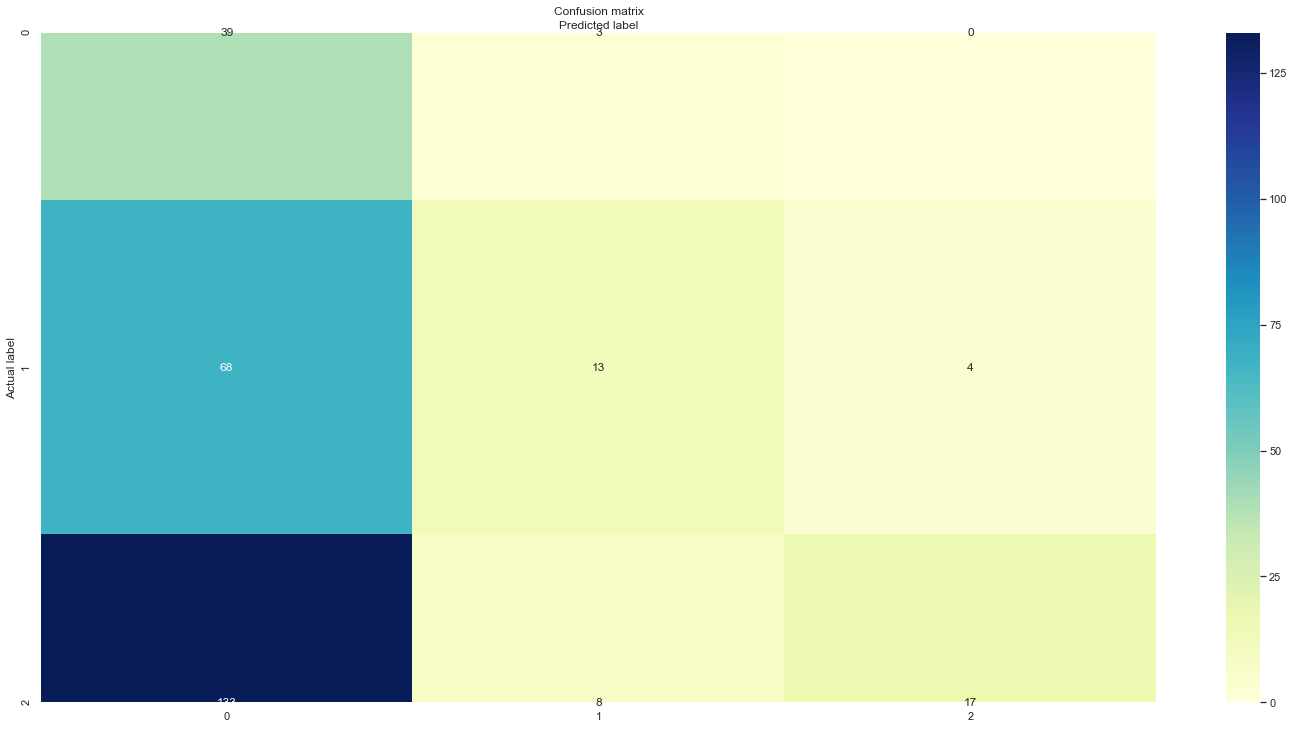

In [117]:
predicted = vote_cls.predict(X_schizo)
cm = confusion_matrix(y_schizo, predicted)

names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [118]:
print(classification_report(y_schizo, predicted))

              precision    recall  f1-score   support

           0       0.16      0.93      0.28        42
           1       0.54      0.15      0.24        85
           2       0.81      0.11      0.19       158

    accuracy                           0.24       285
   macro avg       0.50      0.40      0.24       285
weighted avg       0.63      0.24      0.22       285

